## Loading Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

In [33]:
%matplotlib inline
%matplotlib nbagg

pd.options.display.precision = 10

### Load the full dataset

In [3]:
train_data_path = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/all/train.csv'''

In [4]:
train_data = pd.read_csv(train_data_path, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

### Reduce data set

In [7]:
train_data = train_data.iloc[::2, :] #every second element

### Quick Overview

In [8]:
train_data.acoustic_data.describe()

count    314572740.000000000000000000000000000000000000...
mean     4.51948626572029077408387820469215512275695800...
std      10.7359294596928780407552039832808077335357666...
min     -5474.00000000000000000000000000000000000000000...
25%      2.00000000000000000000000000000000000000000000...
50%      5.00000000000000000000000000000000000000000000...
75%      7.00000000000000000000000000000000000000000000...
max      5310.00000000000000000000000000000000000000000...
Name: acoustic_data, dtype: float64

In [9]:
train_data.time_to_failure.describe()

count    314572740.000000000000000000000000000000000000...
mean     5.67829169963007629462481418158859014511108398...
std      3.67269650907564804143135006597731262445449829...
min      0.00009550396316600001048874313269720914831850...
25%      2.62599699677499964778348839899990707635879516...
50%      5.34979774234999982951421770849265158176422119...
75%      8.17332386907500030304163374239578843116760253...
max      16.1073999990000018556202121544629335403442382...
Name: time_to_failure, dtype: float64

## Failures

In [5]:
#diff = a[n+1] - a[n].In case of a slip (time_to_failure near zero) the following number a[n] is higher than a[n+1]
failure_border = np.where(np.diff(train_data.time_to_failure) > 0)

In [6]:
print(failure_border)

(array([  5656573,  50085877, 104677355, 138772452, 187641819, 218652629,
       245829584, 307838916, 338276286, 375377847, 419368879, 461811622,
       495800224, 528777114, 585568143, 621985672], dtype=int64),)


### build 16 failure arrays and files

In [7]:
failures = []
start = 0
for end in failure_border[0]:
    failures.append(train_data.iloc[start:end])
    start = end + 1
  

In [20]:
for failure in failures:
    print(failure.describe())

          acoustic_data   time_to_failure
count  5.6565730000e+06  5.6565730000e+06
mean   4.5609831253e+00  7.3498299874e-01
std    2.3427842470e+01  4.2417191681e-01
min   -4.6210000000e+03  7.9548092344e-04
25%    2.0000000000e+00  3.6789660732e-01
50%    5.0000000000e+00  7.3499773262e-01
75%    7.0000000000e+00  1.1020988579e+00
max    3.2520000000e+03  1.4690999832e+00
          acoustic_data   time_to_failure
count  4.4429303000e+07  4.4429303000e+07
mean   4.5078125804e+00  5.7707262860e+00
std    1.0900782765e+01  3.3316398207e+00
min   -3.3010000000e+03  6.9548327519e-04
25%    2.0000000000e+00  2.8851988619e+00
50%    5.0000000000e+00  5.7706977350e+00
75%    7.0000000000e+00  8.6562966080e+00
max    3.9140000000e+03  1.1540799987e+01
          acoustic_data   time_to_failure
count  5.4591477000e+07  5.4591477000e+07
mean   4.7972629317e+00  7.0907031973e+00
std    9.4663098144e+00  4.0936752203e+00
min   -3.1120000000e+03  7.9548616395e-04
25%    2.0000000000e+00  3.5459954

### Save each failure to file

In [18]:
for failure in range(0,len(failures)):
    np.save('./failure/failure{}'.format(failure),failures[failure])

### Load failures

### Divide into 16 earthquakes

In [29]:
failure = np.load('./failure/failure{}.npy'.format(0))

<IPython.core.display.Javascript object>


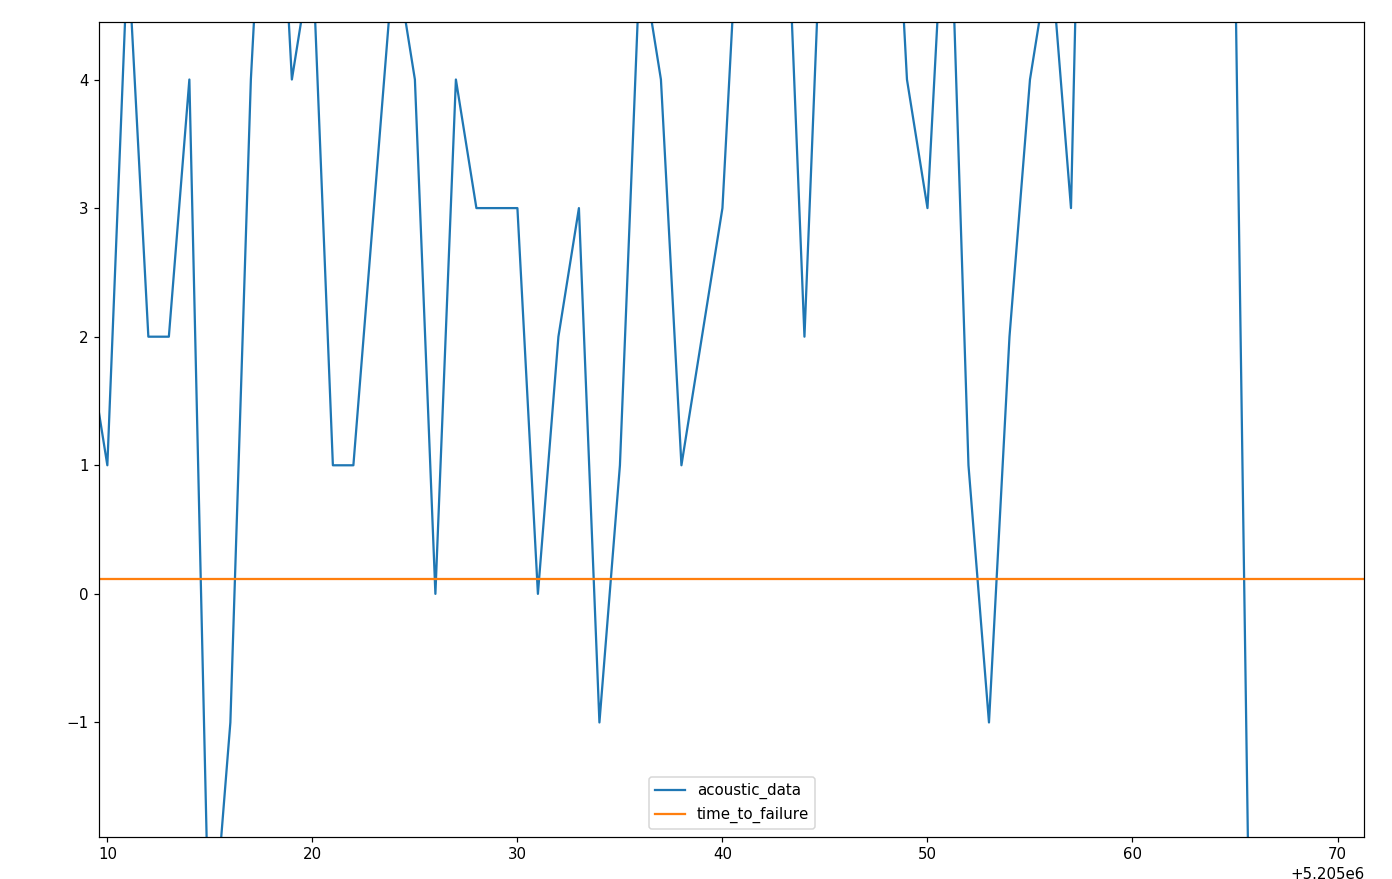

In [37]:
pd.DataFrame(failure,columns=['acoustic_data','time_to_failure']).plot(figsize=(10,8))
plt.tight_layout()
plt.show()

## Autokorrelationen